<a href="https://colab.research.google.com/github/uvais-6/Generative-AI/blob/main/GEN_AI_VAE_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras import layers, Model
from tensorflow.keras import datasets
from tensorflow.keras.losses import MeanSquaredError, KLDivergence, binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from numpy import cov, trace, iscomplexobj, asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from skimage.transform import resize

In [ ]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [ ]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [ ]:
latent_dim = 1024
image_shape = x_train[0].shape
mse_loss = MeanSquaredError()
kl_loss = KLDivergence()

In [ ]:
class VAE(keras.Model):
  def __init__(self, latent_dim, image_shape, beta):
    super(VAE, self).__init__()
    self.latent_dim = latent_dim
    self.image_shape = image_shape
    self.beta = beta

    self.encoder = tf.keras.Sequential([
        layers.Input(shape=image_shape, name="Encoder_Input_Layer"),
        layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation="relu", padding="same", name="Encoder_Conv2D_2"),
        layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation="relu", padding="same", name="Encoder_Conv2D_4"),
        layers.Conv2D(filters=128, kernel_size=3, strides=(2, 2), activation="relu", padding="same", name="Encoder_Conv2D_6"),
        layers.Flatten(name="Encoder_Flatten"),
    ])

    self.z_mean = layers.Dense(latent_dim, name="z_mean")
    self.z_log_var = layers.Dense(latent_dim, name="z_log_var")

    self.decoder = tf.keras.Sequential([
        layers.InputLayer(input_shape=(latent_dim,)),
        layers.Dense(8*8*64, activation="relu"),
        layers.Reshape((8, 8, 64)),
        layers.Conv2DTranspose(64, kernel_size=3, strides=(2, 2), padding="same", activation="relu"),
        layers.Conv2DTranspose(32, kernel_size=3, strides=(2, 2), padding="same", activation="relu"),
        layers.Conv2DTranspose(3, kernel_size=3, strides=(1, 1), padding="same", activation="sigmoid"),
    ])

    self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
    self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

  def encode(self, x):
    encoded = self.encoder(x)
    z_mean, z_log_var = self.z_mean(encoded), self.z_log_var(encoded)
    return z_mean, z_log_var

  def reparameterize(self, z_mean, z_log_var):
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

  def call(self, x):
    mean, logvar = self.encode(x)
    z = self.reparameterize(mean, logvar)
    x_recon = self.decoder(z)
    return x_recon, mean, logvar

  def decode(self, data):
    return self.decoder(data)

  @property
  def metrics(self):
    return [
        self.total_loss_tracker,
        self.reconstruction_loss_tracker,
        self.kl_loss_tracker,
    ]

  def train_step(self, data):
    with tf.GradientTape() as tape:
      z_mean, z_log_var = self.encode(data)
      z = self.reparameterize(z_mean, z_log_var)
      x_reconstruction = self.decoder(z)

      reconstruction_loss = mse_loss(data, x_reconstruction)
      kl_loss_value = kl_loss(z_log_var, z_mean)
      total_loss = reconstruction_loss + self.beta * kl_loss_value

    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss_value)
    return{
        "loss" : self.total_loss_tracker.result(),
        "reconstruction_loss" : self.reconstruction_loss_tracker.result(),
        "kl_loss" : self.kl_loss_tracker.result(),
    }

In [ ]:
vae = VAE(latent_dim, image_shape, 0.3)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
vae.compile(optimizer=keras.optimizers.Adam())
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1)
history = vae.fit(x_train, epochs=50, batch_size=512, callbacks=[early_stopping])

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - kl_loss: -65.1883 - loss: -19.4945 - reconstruction_loss: 0.0620
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - kl_loss: -112.1436 - loss: -33.5899 - reconstruction_loss: 0.0532
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - kl_loss: -112.1693 - loss: -33.6136 - reconstruction_loss: 0.0372
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - kl_loss: -112.1790 - loss: -33.6213 - reconstruction_loss: 0.0324
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - kl_loss: -112.1811 - loss: -33.6240 - reconstruction_loss: 0.0303
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - kl_loss: -112.1846 - loss: -33.6271 - reconstruction_loss: 0.0283
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - kl_loss: -112.1862 - loss: -33.6291 - reconstruction_loss: 0.0268
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - kl_loss: -112.1876 - loss: -33.6309 - reconstruction_loss: 0.0254
Epoch 9/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/st

In [ ]:
def generate_images_from_latent_vectors(vae, num_images_to_generate):
  random_latent_vactors = np.random.normal(size=(num_images_to_generate, vae.latent_dim))
  generated_images = vae.decoder.predict(random_latent_vactors)
  return generated_images

generated_images = generate_images_from_latent_vectors(vae, 20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


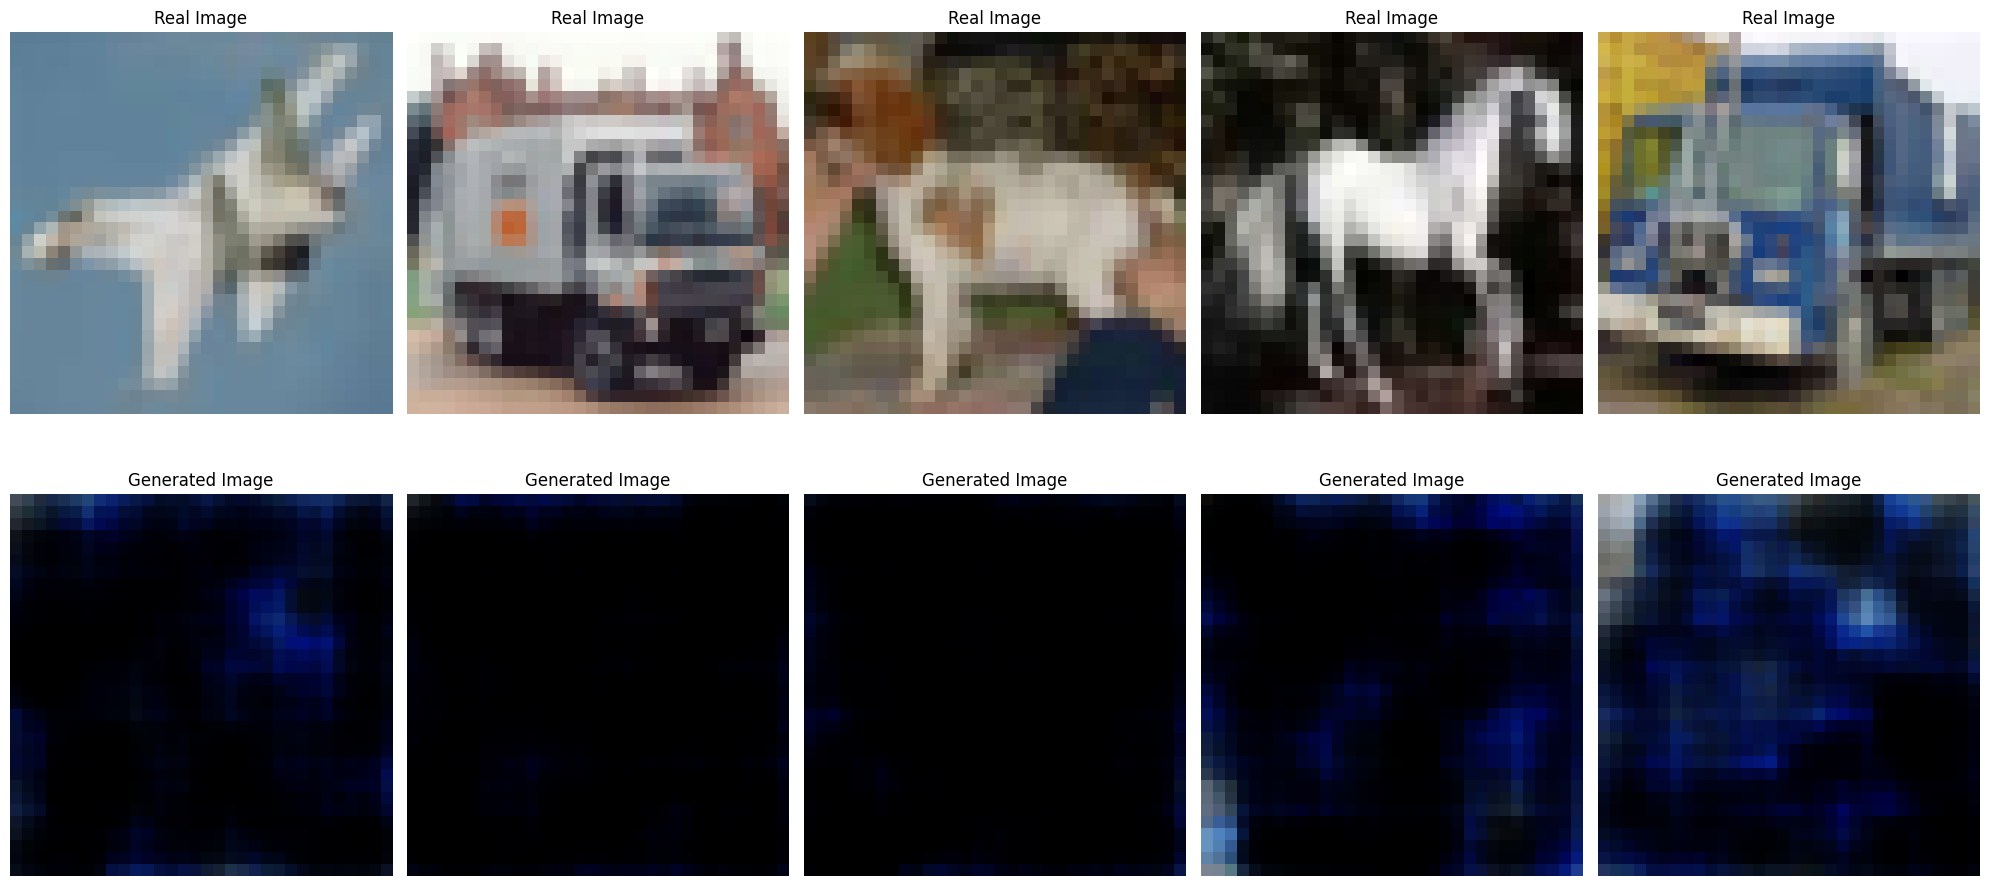

In [ ]:
def plot_real_and_generated_images(real_images, generated_images, num_images_to_generate):
  plt.figure(figsize=(20, 10))
  for i in range(num_images_to_generate):
    plt.subplot(2, num_images_to_generate, i+1)
    plt.imshow(real_images[i+10])
    plt.title('Real Image')
    plt.axis('off')
  for i in range(num_images_to_generate):
    plt.subplot(2, num_images_to_generate, num_images_to_generate+i+1)
    plt.imshow(generated_images[i+10])
    plt.title('Generated Image')
    plt.axis('off')

  plt.tight_layout()
  plt.show()

plot_real_and_generated_images(x_test, generated_images, 5)

In [ ]:
def generate_images_from_latent_vectors(vae, num_images_to_generate):
  random_latent_vactors = np.random.normal(size=(num_images_to_generate, latent_dim))

  generated_images = vae.decoder.predict(random_latent_vactors)
  return generated_images

generated_images = generate_images_from_latent_vectors(vae, 20)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [ ]:
def plot_real_and_generated_images(real_images, generated_images, num_images_to_generate):
  plt.figure(figsize=(20, 10))
  for i in range(num_images_to_generate):
    plt.subplot(2, num_images_to_generate, i+1)
    plt.imshow(real_images[i+10])
    plt.title('Real Image')
    plt.axis('off')
    for i in range(num_images_to_generate):
      plt.subplot(2, num_images_to_generate, num_images_to_generate+i+1)
      plt.imshow(generated_images[i+10])
      plt.title('Generated Image')
      plt.axis('off')
      plt.tight_layout()
      plt.show()



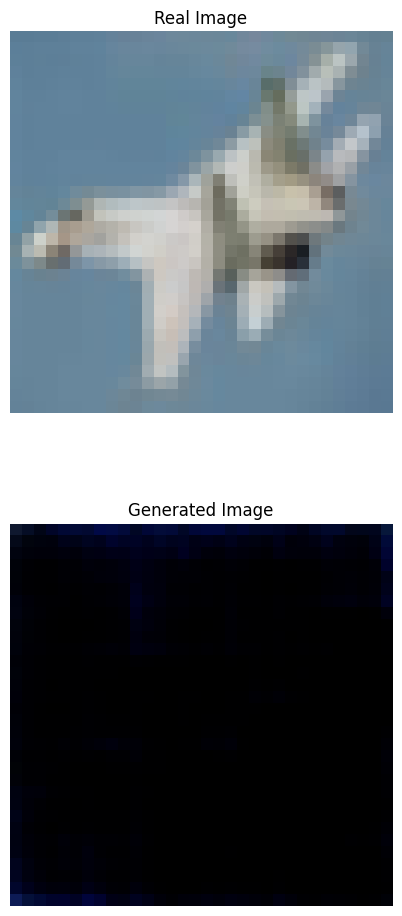

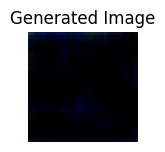

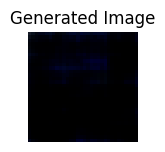

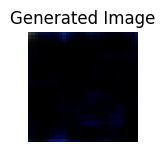

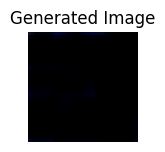

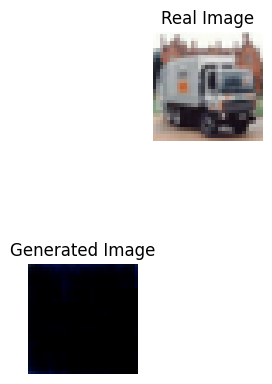

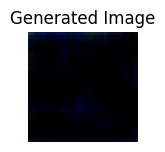

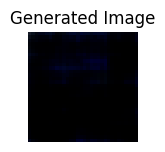

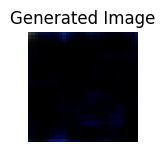

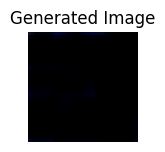

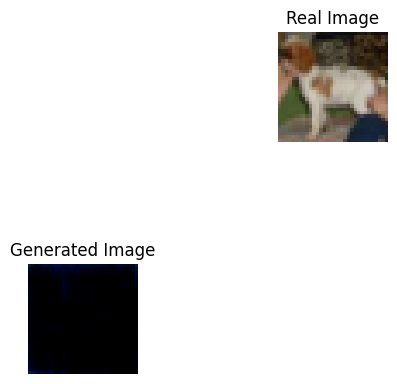

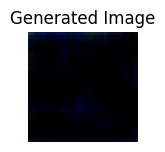

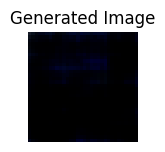

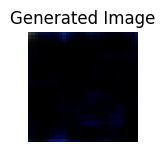

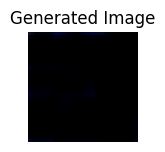

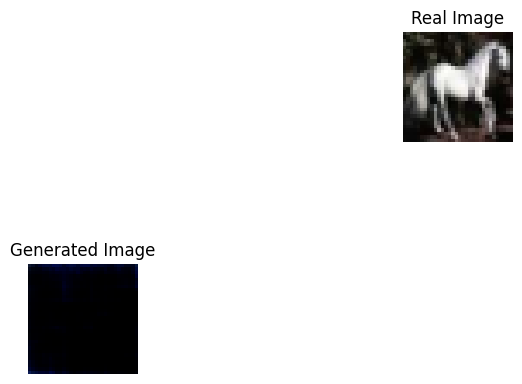

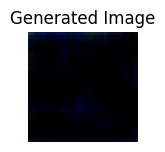

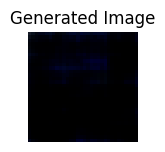

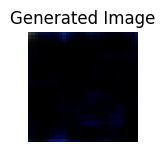

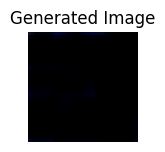

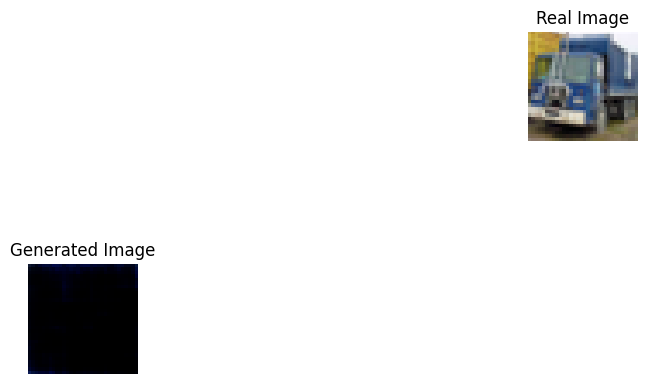

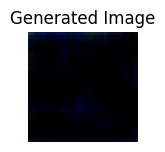

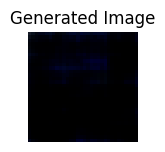

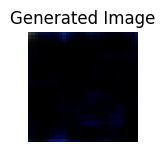

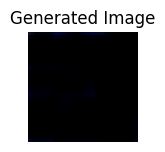

In [ ]:
plot_real_and_generated_images(x_test, generated_images, 5)

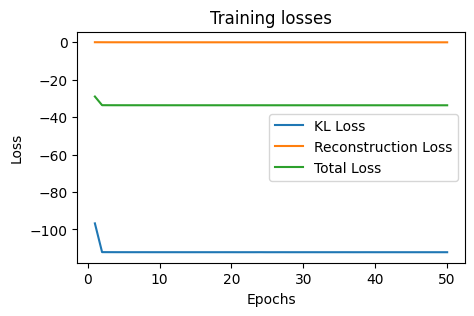

In [ ]:
kl_loss_values = history.history['kl_loss']
reconstruction_loss_values = history.history['reconstruction_loss']

total_loss_values = history.history['loss']

epochs = range(1, len(kl_loss_values) + 1)
plt.figure(figsize=(5, 3))
plt.plot(epochs, kl_loss_values, label='KL Loss')
plt.plot(epochs, reconstruction_loss_values, label='Reconstruction Loss')
plt.plot(epochs, total_loss_values, label='Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training losses')
plt.legend()
plt.show()